## Test01_2 MNE

เปลี่ยนการเขียน csp และก่อนเข้า csp ลองแยก split

- Preprocessing
- Feature Extraction
- Classification

link to dataset: https://ieee-dataport.org/documents/upper-limb-rehabilitation-motor-imagery-eeg-signals - 1398.18 Baht

- EEG Placement 10-20 electrode system

- Notch filter 50 hz applied

- 8th order chebyshev bandpass filter 0.01 hz - 200hz appiled

- Sampling rate 500 Hz

**Planning: Use only 1 subjects for testing code.**

1. Read all .set files, find only S1R1 - S1R10
2. merge the files in to 1 set
3. Preprocessing (Fliter + Baseline correction + Epoching)
4. Epoching only Flexion and Extension 

In [1]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import onnxruntime
import torch
import seaborn as sns
import pandas as pd
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from IPython.display import display

#### Step 1: READ Dataset 

- read only S1R1 - S1R10
- rename label from 'elbow flexion' to 'S1R1_elbow flexion' for easy to concat

In [2]:
DataFolder = 'G:\\KMUTT\\Y3_Term2\\Studio_OpenTopic\\StudioV_opentopics\\Dataset_used'

# Merge all files into 1 dataset
S1_EpochList = []
all_event_names = set() #Check event name

# Sorted R1-R10 and Read files
def extract_run_num(name):
    match = re.search(r'R(\d+)', name)
    return int(match.group(1)) if match else 0

for file_name in sorted(os.listdir(DataFolder), key=extract_run_num):
    if file_name.startswith("S1R") and file_name.endswith(".set"):
        files_all = os.path.join(DataFolder, file_name)
        # print(f"Reading {file_name} ...")
        # print(files_all)
        
        # read files
        epochs = mne.io.read_epochs_eeglab(files_all)
        
        # rename event label EX 'shoulder adduction' → 'S1R1_shoulder adduction'
        file_id = file_name.replace('.set', '')
        new_event_id = {f"{file_id}_{k}": v for k, v in epochs.event_id.items()}
        epochs.event_id = new_event_id
        
        S1_EpochList.append(epochs)
        
        all_event_names.update(epochs.event_id.keys()) #Check event name

#Check all combine
combined_epochs = mne.concatenate_epochs(S1_EpochList)

print(f"Total epochs: {len(combined_epochs)}")

#Check event name
# print("\n Event names:")
# for i in sorted(all_event_names):
#     print("-", i)

# combined_epochs
# combined_epochs.event_id

Extracting parameters from G:\KMUTT\Y3_Term2\Studio_OpenTopic\StudioV_opentopics\Dataset_used\S1R1.set...
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from G:\KMUTT\Y3_Term2\Studio_OpenTopic\StudioV_opentopics\Dataset_used\S1R2.set...
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from G:\KMUTT\Y3_Term2\Studio_OpenTopic\StudioV_opentopics\Dataset_used\S1R3.set...
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from G:\KMUTT\Y3_Term2\Studio_OpenTopic\StudioV_opentopics\Dataset_used\S1R4.set...
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from G:\KMUTT\Y3_Term2\Studio_OpenTopic\StudioV_opentopics\Dataset_used\S1R5.set...
Not setting me

In [3]:
S1_EpochList

[<EpochsEEGLAB | 180 events (all good), -1 – 1.998 s (baseline off), ~33.0 MiB, data loaded,
  'S1R1_forearm supination': 30
  'S1R1_elbow extension': 30
  'S1R1_forearm pronation': 30
  'S1R1_shoulder adduction': 30
  'S1R1_shoulder abduction': 30
  'S1R1_elbow flexion': 30>,
 <EpochsEEGLAB | 180 events (all good), -1 – 1.998 s (baseline off), ~33.0 MiB, data loaded,
  'S1R2_forearm pronation': 30
  'S1R2_elbow extension': 30
  'S1R2_elbow flexion': 30
  'S1R2_forearm supination': 30
  'S1R2_shoulder abduction': 30
  'S1R2_shoulder adduction': 30>,
 <EpochsEEGLAB | 180 events (all good), -1 – 1.998 s (baseline off), ~33.0 MiB, data loaded,
  'S1R3_elbow extension': 30
  'S1R3_elbow flexion': 30
  'S1R3_shoulder adduction': 30
  'S1R3_shoulder abduction': 30
  'S1R3_forearm pronation': 30
  'S1R3_forearm supination': 30>,
 <EpochsEEGLAB | 180 events (all good), -1 – 1.998 s (baseline off), ~33.0 MiB, data loaded,
  'S1R4_elbow flexion': 30
  'S1R4_elbow extension': 30
  'S1R4_shoulder 

##### Rename labels after concat

In [4]:
# Mapping: 'S1R1_elbow flexion' → 'elbow flexion'
label_map = {}
for K in combined_epochs.event_id:
    new_label = K.split('_', 1)[-1]
    label_map[K] = new_label

# สร้าง event_id 
new_event_id = {}
new_events = []

for I in combined_epochs.events:
    old_event_id = I[2]
    K = [k for k, v in combined_epochs.event_id.items() if v == old_event_id][0]
    new_label = label_map[K]

    if new_label not in new_event_id:
        new_event_id[new_label] = len(new_event_id) + 1

    new_events.append([I[0], I[1], new_event_id[new_label]])

# อัปเดต combined_epochs
combined_epochs.events = np.array(new_events)
combined_epochs.event_id = new_event_id


##### Test Combined data

In [5]:
# combined_epochs.equalize_event_counts
combined_epochs.event_id
# combined_epochs

{'forearm supination': 1,
 'elbow extension': 2,
 'forearm pronation': 3,
 'shoulder adduction': 4,
 'shoulder abduction': 5,
 'elbow flexion': 6}

Event counts: {1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300}
Using matplotlib as 2D backend.


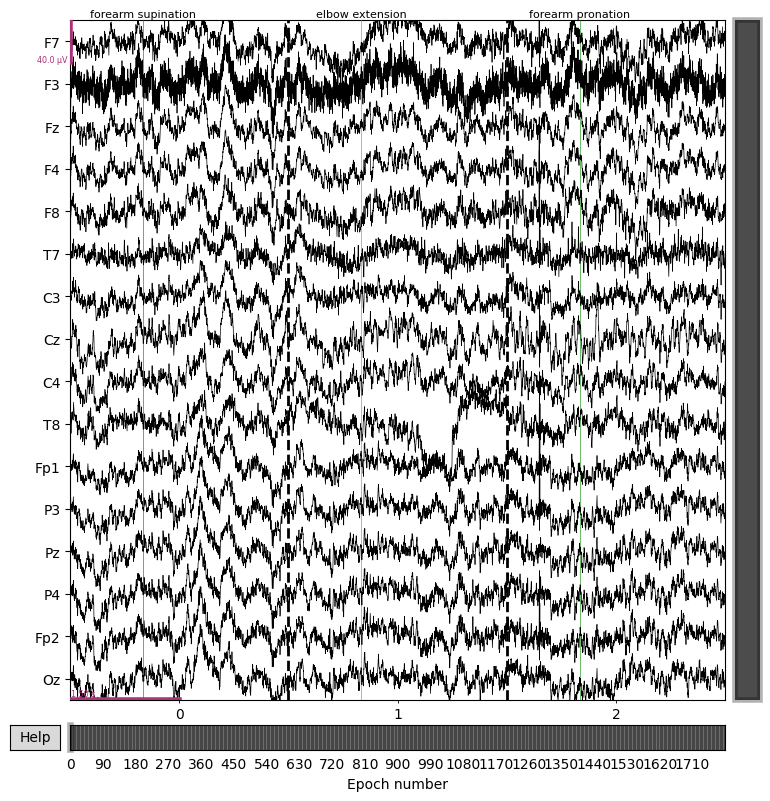

Epoch 0: forearm supination
Epoch 1: elbow extension
Epoch 2: forearm pronation
Epoch 3: shoulder adduction
Epoch 4: shoulder adduction
Epoch 5: shoulder abduction
Epoch 6: forearm pronation
Epoch 7: shoulder adduction
Epoch 8: forearm pronation
Epoch 9: elbow extension
Epoch 10: forearm pronation
Epoch 11: elbow extension
Epoch 12: forearm supination
Epoch 13: elbow extension
Epoch 14: elbow extension
Epoch 15: forearm supination
Epoch 16: forearm pronation
Epoch 17: shoulder adduction
Epoch 18: shoulder abduction
Epoch 19: forearm supination
Epoch 20: forearm pronation
Epoch 21: shoulder adduction
Epoch 22: forearm supination
Epoch 23: shoulder abduction
Epoch 24: elbow extension
Epoch 25: forearm pronation
Epoch 26: forearm supination
Epoch 27: elbow flexion
Epoch 28: shoulder abduction
Epoch 29: forearm supination
Epoch 30: forearm supination
Epoch 31: elbow flexion
Epoch 32: elbow extension
Epoch 33: shoulder abduction
Epoch 34: elbow extension
Epoch 35: shoulder adduction
Epoch 3

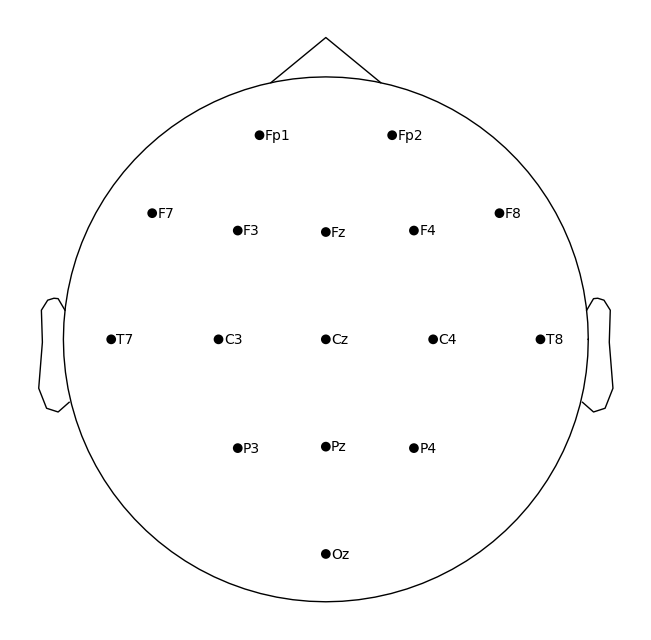

In [6]:
# Check event occurs
event_ids = combined_epochs.events[:, 2] #column 3

unique, counts = np.unique(event_ids, return_counts=True)

event_counts = dict(zip(unique, counts))
print("Event counts:", event_counts)

#Check sensor location
# Pic = combined_epochs.plot_sensors(show_names=True, sphere =0.1) 

# Plot epochs and show event names
fig = combined_epochs.plot(n_epochs=3,events=True, event_id = True)


# Plot each epoch name
for i in range(len(combined_epochs)):
    event_id = combined_epochs.events[i, 2]
    label = [k for k, v in combined_epochs.event_id.items() if v == event_id]
    print(f"Epoch {i}: {label[0] if label else 'Unknown'}")

Pic = combined_epochs.plot_sensors(show_names=True, sphere =0.125) #ยิ่งเพิ่มยิ่งลดขนาด

In [7]:
#plot histogram


### Step 2: Preprocessing 

#### Bandpass filter

In [8]:
#copy old dataset
copy_combined = combined_epochs.copy()

#Apply bandpass
filtered_epochs = copy_combined.filter(l_freq=8.0, h_freq=30.0)

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.5s
[Parallel(n_job

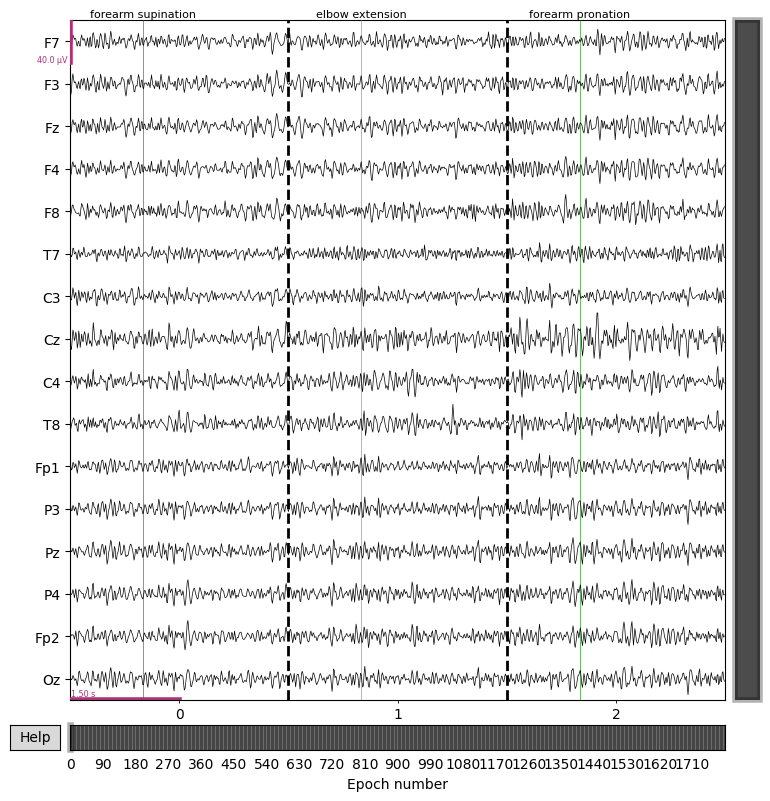

In [9]:
#Check waveform and frequency

figwave = filtered_epochs.plot(n_epochs=3, events=True, event_id=True)

# %matplotlib inline
# psd = filtered_epochs.compute_psd(method='multitaper', fmax=60) #multi=ใช้หลาย "Taper" (DPSS) ในการลด variance
# figpsdpick = psd.plot(picks=['C3', 'C4'], average=False)
# figpsd = psd.plot()

In [10]:
filtered_epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, Fp1, P3, Pz, P4, Fp2, Oz
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 highpass: 8.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 500.0 Hz
>

##### Check Bandpass filter

- Print info method

In [11]:
print("High-pass:", filtered_epochs.info['highpass'])
print("Low-pass :", filtered_epochs.info['lowpass'])


High-pass: 8.0
Low-pass : 30.0


- Check FFT Graph

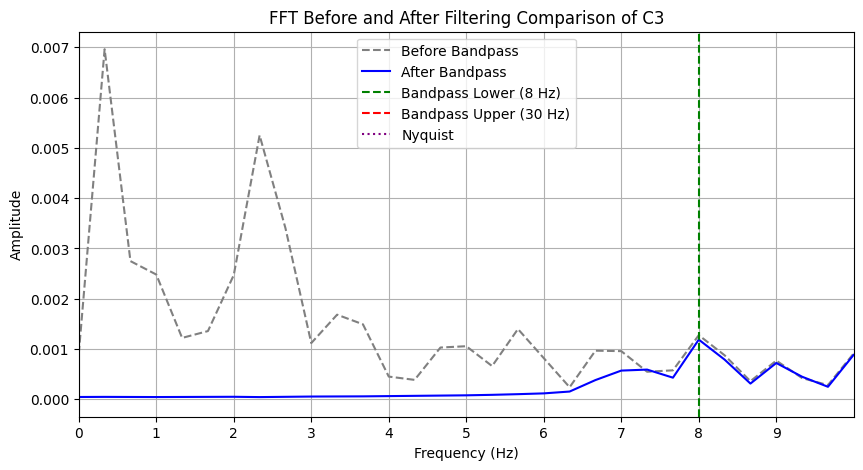

In [12]:
channel_nam = 'C3'
channel_id = combined_epochs.ch_names.index(channel_nam)  # ก่อน filter
fis = combined_epochs.info['sfreq']

# สัญญาณก่อน filter
signal_before = combined_epochs.get_data()[0, channel_id, :]
# สัญญาณหลัง filter
signal_after = filtered_epochs.get_data()[0, channel_id, :]

# FFT
nu = len(signal_after)
freqs = np.fft.rfftfreq(nu, 1/fis)
fft_before = np.abs(np.fft.rfft(signal_before))
fft_after = np.abs(np.fft.rfft(signal_after))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_before, label="Before Bandpass", color='gray', linestyle='--')
plt.plot(freqs, fft_after, label="After Bandpass", color='blue')
plt.axvline(8, color='green', linestyle='--', label='Bandpass Lower (8 Hz)')
plt.axvline(30, color='red', linestyle='--', label='Bandpass Upper (30 Hz)')
plt.axvline(fis/2, color='purple', linestyle=':', label='Nyquist')

plt.title(f"FFT Before and After Filtering Comparison of {channel_nam}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
# plt.xlim(0, fs / 2)
# plt.ylim(0, 0.0015)  
plt.xlim(0,10)
plt.xticks(np.arange(0, 10, 1))  # ticks each 1 Hz
# plt.ylim(0,0.005)
# plt.yticks(np.arange(0, 0.005, 0.001))  # ticks each 1 Hz
plt.show()


In [13]:
# ค่า FFT จ้
print(max(fft_after))

0.0011861912237820266


In [14]:
# # กำหนดชื่อ channel ที่ต้องการดู
# channel_name = 'Cz'
# channel_index = combined_epochs.ch_names.index(channel_name)

# # ข้อมูล
# fs = combined_epochs.info['sfreq']
# data_before = combined_epochs.get_data()  # (n_epochs, n_channels, n_times)
# data_after = filtered_epochs.get_data()

# # จำนวน epoch
# n_epochs = data_before.shape[0]

# # ใช้แค่ N trials แรก (ดูภาพรวมแบบคลื่น)
# N = 2

# # Plot เปรียบเทียบ
# plt.figure(figsize=(14, 6))

# for i in range(N):
#     # ก่อน filter
#     signal_b = data_before[i, channel_index, :]
#     fft_b = np.abs(np.fft.rfft(signal_b))
#     freqs = np.fft.rfftfreq(len(signal_b), 1/fs)
#     plt.plot(freqs, fft_b, label=f'Before Epoch {i+1}', linestyle='--', alpha=0.5)
    
#     # หลัง filter
#     signal_a = data_after[i, channel_index, :]
#     fft_a = np.abs(np.fft.rfft(signal_a))
#     plt.plot(freqs, fft_a, label=f'After Epoch {i+1}', alpha=0.9)

# plt.xlim(0,250)
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Amplitude")
# plt.title(f"FFT Comparison Before vs After Filter ({channel_name})")
# plt.legend(loc='upper right', ncol=2)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

#### Downsampling

Because 

In [15]:
downsampled_epochs = filtered_epochs.copy().resample(128)#128 100
downsampled_epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, Fp1, P3, Pz, P4, Fp2, Oz
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 highpass: 8.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 128.0 Hz
>

##### Check Downsampling

- Check info downsampling freq

In [16]:
print("Before Sampling rate (Hz):", filtered_epochs.info['sfreq'])
print("After Sampling rate (Hz):", downsampled_epochs.info['sfreq'])

Before Sampling rate (Hz): 500.0
After Sampling rate (Hz): 128.0


- FFT method

In [17]:
# #Check channel names
# for idx, name in enumerate(downsampled_epochs.ch_names):
#     print(f"{idx}: {name}")

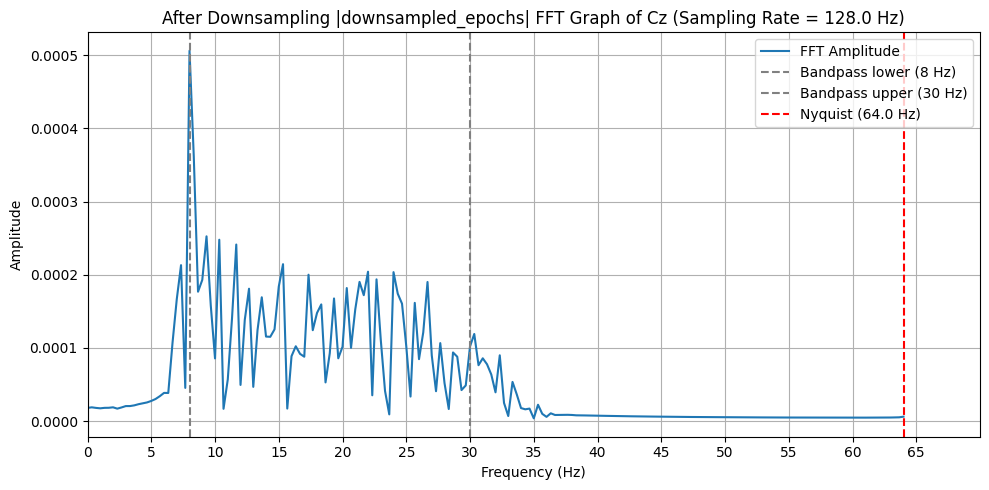

In [18]:
# Pick channel
chan_name = 'Cz'
chan_index = downsampled_epochs.ch_names.index(chan_name)

# Get signal
s = downsampled_epochs.get_data()[0, chan_index, :]
fs = downsampled_epochs.info['sfreq']

# FFT
n = len(s)
freqs = np.fft.rfftfreq(n, 1/fs)
fft_vals = np.abs(np.fft.rfft(s))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_vals, label='FFT Amplitude')
plt.axvline(8, color='gray', linestyle='--', label='Bandpass lower (8 Hz)')
plt.axvline(30, color='gray', linestyle='--', label='Bandpass upper (30 Hz)')
plt.axvline(fs/2, color='red', linestyle='--', label=f'Nyquist ({fs/2:.1f} Hz)')
plt.title(f"After Downsampling |downsampled_epochs| FFT Graph of {chan_name} (Sampling Rate = {fs} Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.xlim(0, fs / 2)
plt.xlim(0,70)
plt.xticks(np.arange(0, 70, 5))  # ticks each 1 Hz
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


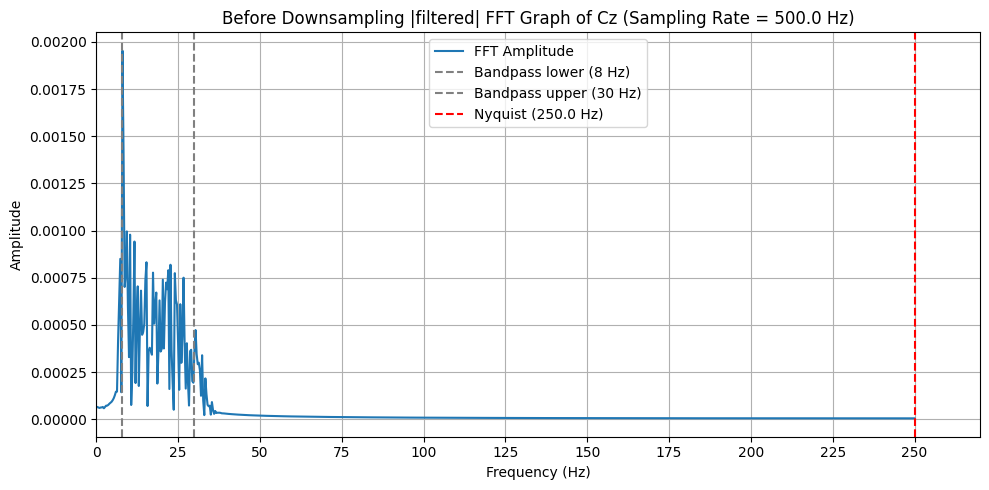

In [19]:
# Pick channel
chan_namee = 'Cz'
chan_indexx = filtered_epochs.ch_names.index(chan_namee)

# Get signal
ss = filtered_epochs.get_data()[0, chan_indexx, :]
fss = filtered_epochs.info['sfreq']

# FFT
nn = len(ss)
freqss = np.fft.rfftfreq(nn, 1/fss)
fft_valss = np.abs(np.fft.rfft(ss))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqss, fft_valss, label='FFT Amplitude')
plt.axvline(8, color='gray', linestyle='--', label='Bandpass lower (8 Hz)')
plt.axvline(30, color='gray', linestyle='--', label='Bandpass upper (30 Hz)')
plt.axvline(fss/2, color='red', linestyle='--', label=f'Nyquist ({fss/2:.1f} Hz)')
plt.title(f"Before Downsampling |filtered| FFT Graph of {chan_namee} (Sampling Rate = {fss} Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.xlim(0, fs / 2)
plt.xlim(0, 270)
plt.xticks(np.arange(0, 270, 25))  # ticks each 1 Hz
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


- Calculate sample per epoch

In [20]:
fs = filtered_epochs.info['sfreq']
fs2 = downsampled_epochs.info['sfreq']

#Check time per epoch
tmin = filtered_epochs.tmin
tmax = filtered_epochs.tmax
duration = tmax - tmin 

#Check time per epoch
tmin2 = downsampled_epochs.tmin
tmax2 = downsampled_epochs.tmax
duration2 = tmax2 - tmin2

# calculate expected sample per 1 epoch
# 128 dot per 1 sec so 2.99 sec = 2.99x128 + 1(from -1 start)
expected_samples = int(duration * fs) + 1 
expected_samples2 = int(duration2 * fs2) + 1

# Actual sample
actual_samples = filtered_epochs.get_data().shape[2]
actual_samples2 = downsampled_epochs.get_data().shape[2]

print(f"Before Sampling rate: {fs} Hz")
print(f"After Sampling rate: {fs2} Hz \n")

print(f"Before Epoch duration: {duration:.4f} seconds")
print(f"After Epoch duration: {duration2:.4f} seconds \n")


print(f"Before Expected samples per epoch: {expected_samples:.4f}")
print(f"After Expected samples per epoch: {expected_samples2:.4f} \n")

print(f"Before Actual samples per epoch  : {actual_samples}")
print(f"After Actual samples per epoch  : {actual_samples2} \n")


Before Sampling rate: 500.0 Hz
After Sampling rate: 128.0 Hz 

Before Epoch duration: 2.9980 seconds
After Epoch duration: 2.9922 seconds 

Before Expected samples per epoch: 1500.0000
After Expected samples per epoch: 384.0000 

Before Actual samples per epoch  : 1500
After Actual samples per epoch  : 384 



In [21]:
tmin = filtered_epochs.tmin
tmax = filtered_epochs.tmax
tmin2 = downsampled_epochs.tmin
tmax2 = downsampled_epochs.tmax

print(tmin,tmin2,tmax,tmax2)

-1.0 -1.0 1.998 1.9921875


#### ICA
- จัดการ Artifacts EX. eye artifact (2-5 Hz), muscle movement, heartbeat

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.4s.


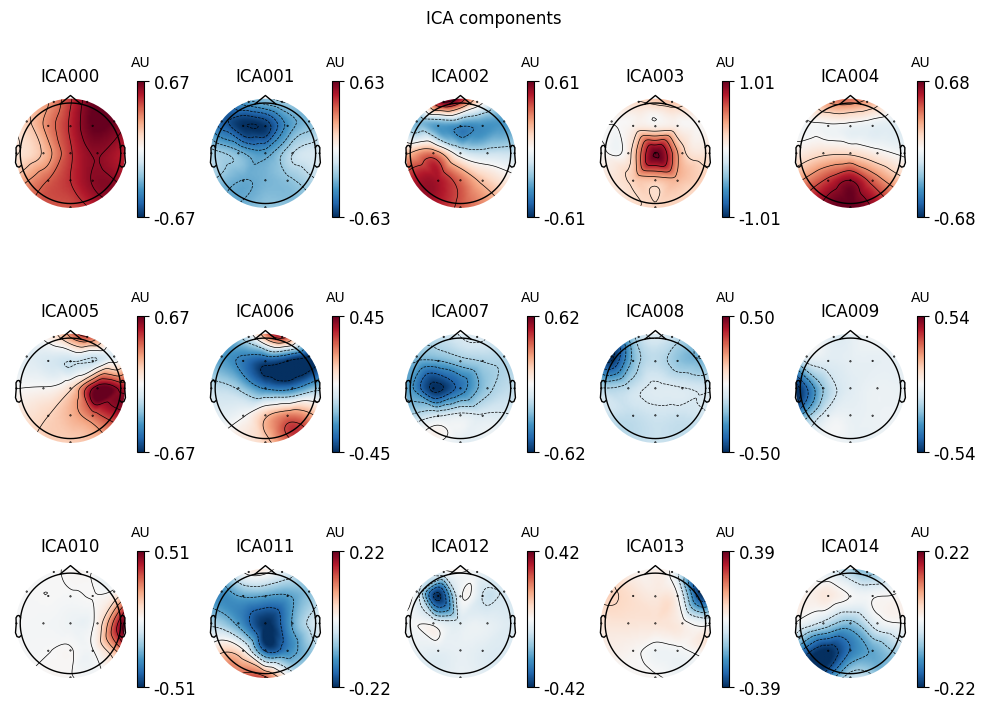

C:\Users\HP\AppData\Local\Temp\ipykernel_29248\3288215031.py:14: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels = label_components(ICAprocess, ica, method='iclabel')
C:\Users\HP\AppData\Local\Temp\ipykernel_29248\3288215031.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(ICAprocess, ica, method='iclabel')
C:\Users\HP\AppData\Local\Temp\ipykernel_29248\3288215031.py:14: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use th

Component 0: heart beat
Component 1: brain
Component 2: brain
Component 3: brain
Component 4: brain
Component 5: brain
Component 6: brain
Component 7: brain
Component 8: heart beat
Component 9: heart beat
Component 10: heart beat
Component 11: brain
Component 12: brain
Component 13: brain
Component 14: heart beat


In [22]:
#make a goddam copy
ICAprocess = downsampled_epochs.copy()

#ICA Object
ica = mne.preprocessing.ICA(n_components=15, random_state=42, max_iter='auto')

#Fit ICA
ica.fit(ICAprocess)

#PlotComponents: topomap and layout
fig = ica.plot_components(colorbar=True)

#Label components using MNE ICALabel
labels = label_components(ICAprocess, ica, method='iclabel')
for i, label in enumerate(labels['labels']):
    print(f"Component {i}: {label}")

In [23]:
#Delete components except brain
exclude_idx = [i for i, label in enumerate(labels['labels']) if label in ['eye', 'muscle', 'heart beat']]
# ica.exclude = [0,8,9,10,14]

#Make a copy and Apply ICA
# CleanAlready = ICAprocess.copy()
# ica.apply(CleanAlready)
CleanAlready = ica.apply(ICAprocess, exclude = exclude_idx)


Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 5 ICA components
    Projecting back using 16 PCA components


##### Check ICA

- Check exclude

In [24]:
print("Excluded ICA components:", ica.exclude)

Excluded ICA components: []


- Check ERP waveform (Use overlay to plot both graph)

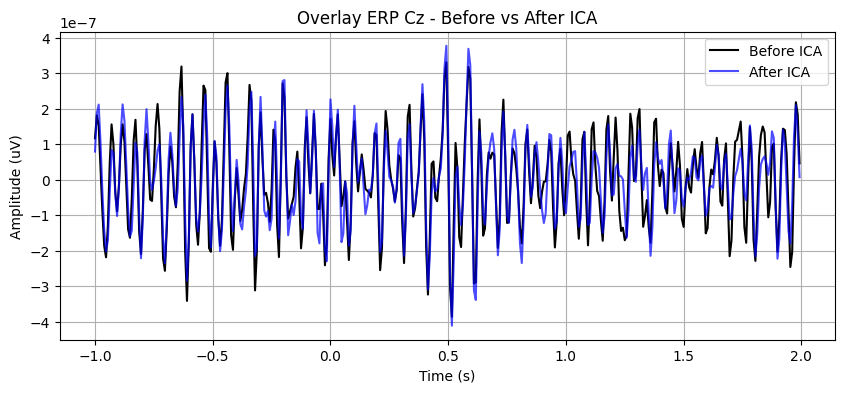

In [25]:
before0 = downsampled_epochs.average()
after0 = CleanAlready.average()

#overlay graph with matplotlib
chn_name = 'Cz'
plt.figure(figsize=(10, 4))
plt.plot(before0.times, before0.data[before0.ch_names.index(chn_name)], label='Before ICA', color='black')
plt.plot(after0.times, after0.data[after0.ch_names.index(chn_name)], label='After ICA', color='blue',alpha=0.7 )

plt.title(f"Overlay ERP {chn_name} - Before vs After ICA")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.grid(True)
plt.legend()
plt.show()


- Check plot source

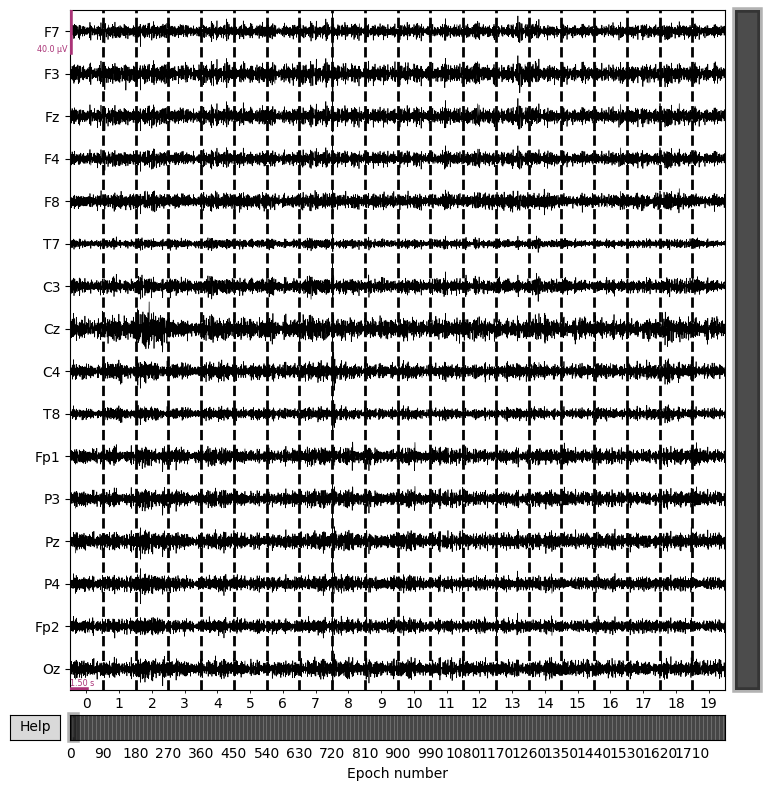

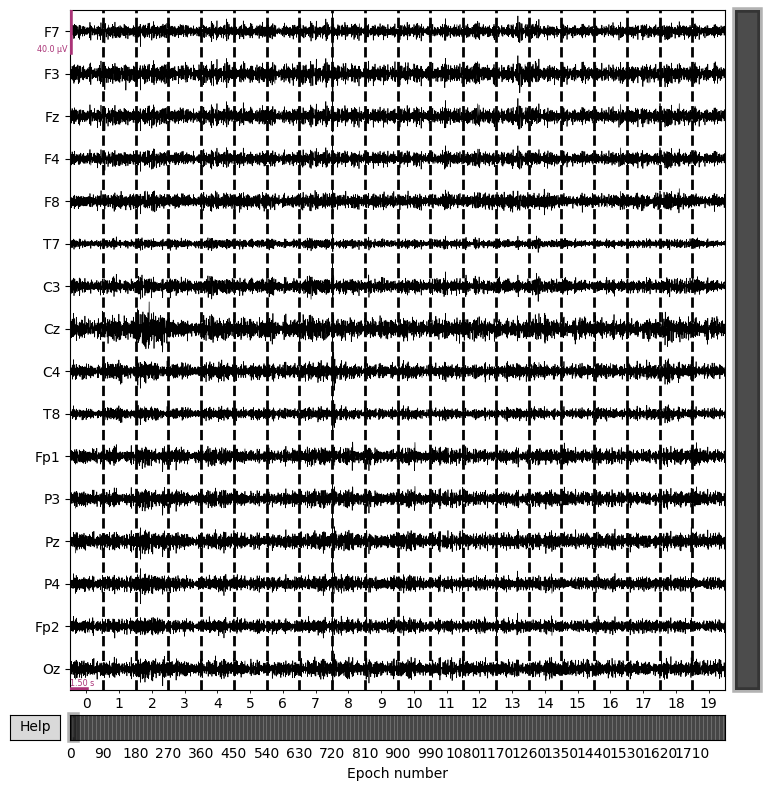

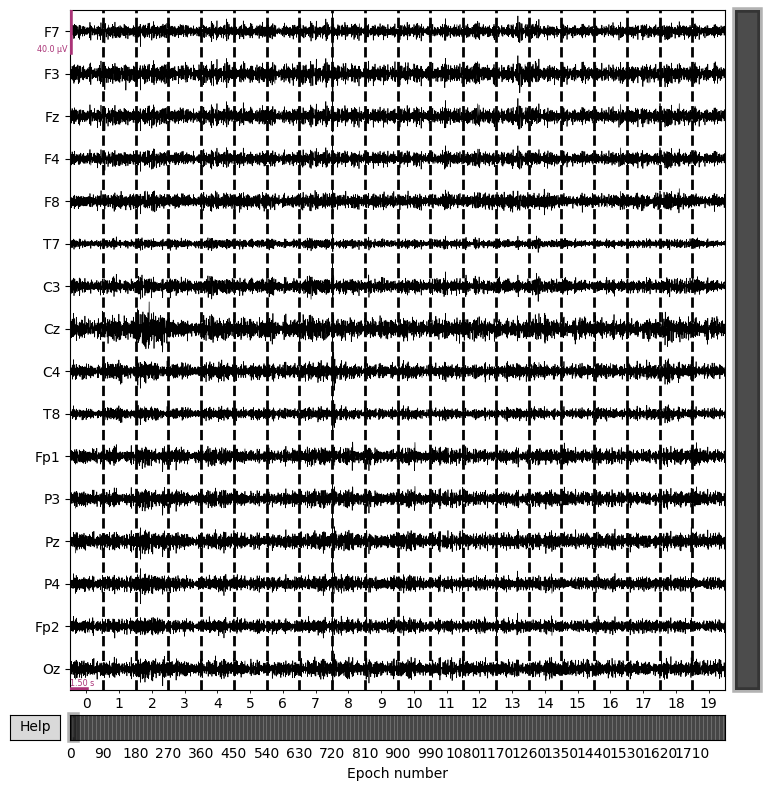

In [26]:
# Fig9 = ica.plot_sources(downsampled_epochs, start=0, stop=2, title='Before')
# Fig10 = ica.plot_sources(CleanAlready, start=0, stop=2, title='After')

ICAprocess.plot()
CleanAlready.plot()


In [27]:
# fikk = ica.plot_properties(CleanAlready, picks=ica.exclude)

In [28]:
#Test after ICA
CleanAlready

<EpochsArray | 1800 events (all good), -1 – 1.992 s (baseline off), ~84.4 MiB, data loaded,
 'forearm supination': 300
 'elbow extension': 300
 'forearm pronation': 300
 'shoulder adduction': 300
 'shoulder abduction': 300
 'elbow flexion': 300>

#### Epoching + Baseline Correction


- Check Baseline done ?

In [29]:
print(CleanAlready.baseline)

None


In [30]:
#Epoching
target_classes = [
    'forearm supination',
    'elbow extension',
    'forearm pronation',
    'shoulder adduction',
    'shoulder abduction',
    'elbow flexion'
]

#Select Class from dataset
Selected_epochs = CleanAlready[target_classes]
Selected_epochs

<EpochsArray | 1800 events (all good), -1 – 1.992 s (baseline off), ~84.4 MiB, data loaded,
 'forearm supination': 300
 'elbow extension': 300
 'forearm pronation': 300
 'shoulder adduction': 300
 'shoulder abduction': 300
 'elbow flexion': 300>

In [31]:
#epoch range
print(Selected_epochs.tmin, Selected_epochs.tmax)

-1.0 1.9921875


In [32]:
#Baseline Correction

#backup
Selectedtuna = Selected_epochs.copy()

Selectedtuna.apply_baseline(baseline=(-0.5, 0))
print("Baseline applied:", Selectedtuna.baseline)
print("Epoch shape:", Selectedtuna.get_data().shape)  # (n_epochs, n_channels, n_times)

Applying baseline correction (mode: mean)


Baseline applied: (-0.5, 0.0)
Epoch shape: (1800, 16, 384)


##### Check Baseline Correction

In [33]:
#Check Before After
before = Selected_epochs.copy().get_data()
after = Selectedtuna.get_data()
print(np.allclose(before, after))  #False = applied

False


In [34]:
#Check offset
before = Selected_epochs.copy().get_data()
after = Selectedtuna.get_data()

print(np.mean(before)) 
print(np.mean(after))    #should near 0


1.8771031242459087e-10
-7.530126473902135e-10


Need more than one channel to make topography for eeg. Disabling interactivity.


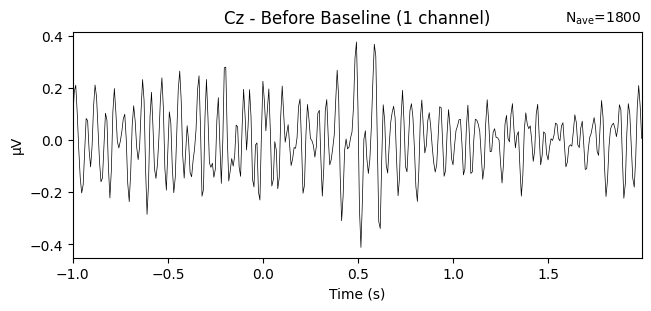

Need more than one channel to make topography for eeg. Disabling interactivity.


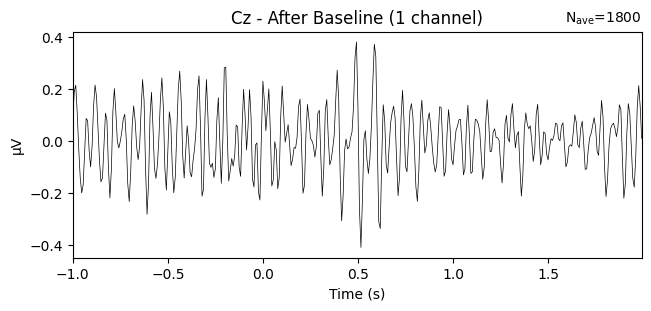

In [35]:
#Check Visual
evoked_before = Selected_epochs.average()
evoked_after = Selectedtuna.average()

f1 = evoked_before.plot(picks='Cz', titles='Cz - Before Baseline')
f2 = evoked_after.plot(picks='Cz', titles='Cz - After Baseline')



In [36]:
# #Plot Image HeatMap
# f4 = Selected_epochs.plot_image(picks='Fp1', combine='mean', title='Before Baseline')
# f5 = Selectedtuna.plot_image(picks='Fp1', combine='mean', title='After Baseline')

- Check by fft map

In [37]:
# #Before
# # Pick channel
# chan_name = 'C3'
# chan_index = Selected_epochs.ch_names.index(chan_name)

# # Get signal
# s = Selected_epochs.get_data()[0, chan_index, :]
# fs = Selected_epochs.info['sfreq']

# # FFT
# n = len(s)
# freqs = np.fft.rfftfreq(n, 1/fs)
# fft_vals = np.abs(np.fft.rfft(s))

# # Plot
# plt.figure(figsize=(10, 4))
# plt.plot(freqs, fft_vals, label='FFT Amplitude')
# plt.axvline(8, color='gray', linestyle='--', label='Bandpass lower (8 Hz)')
# plt.axvline(30, color='gray', linestyle='--', label='Bandpass upper (30 Hz)')
# plt.axvline(fs/2, color='red', linestyle='--', label=f'Nyquist ({fs/2:.1f} Hz)')
# plt.title(f"Before Baseline FFT Spectrum of {chan_name} (Sampling Rate = {fs} Hz)")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Amplitude")
# # plt.xlim(0, fs / 2)
# plt.xlim(0, 10)
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [38]:
# #After
# # Pick channel
# chan_name = 'C3'
# chan_index = Selectedtuna.ch_names.index(chan_name)

# # Get signal
# s = Selectedtuna.get_data()[0, chan_index, :]
# fs = Selectedtuna.info['sfreq']

# # FFT
# n = len(s)
# freqs = np.fft.rfftfreq(n, 1/fs)
# fft_vals = np.abs(np.fft.rfft(s))

# # Plot
# plt.figure(figsize=(10, 4))
# plt.plot(freqs, fft_vals, label='FFT Amplitude')
# plt.axvline(8, color='gray', linestyle='--', label='Bandpass lower (8 Hz)')
# plt.axvline(30, color='gray', linestyle='--', label='Bandpass upper (30 Hz)')
# plt.axvline(fs/2, color='red', linestyle='--', label=f'Nyquist ({fs/2:.1f} Hz)')
# plt.title(f"After Baseline FFT Spectrum of {chan_name} (Sampling Rate = {fs} Hz)")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Amplitude")
# # plt.xlim(0, fs / 2)
# plt.xlim(0, 10)
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


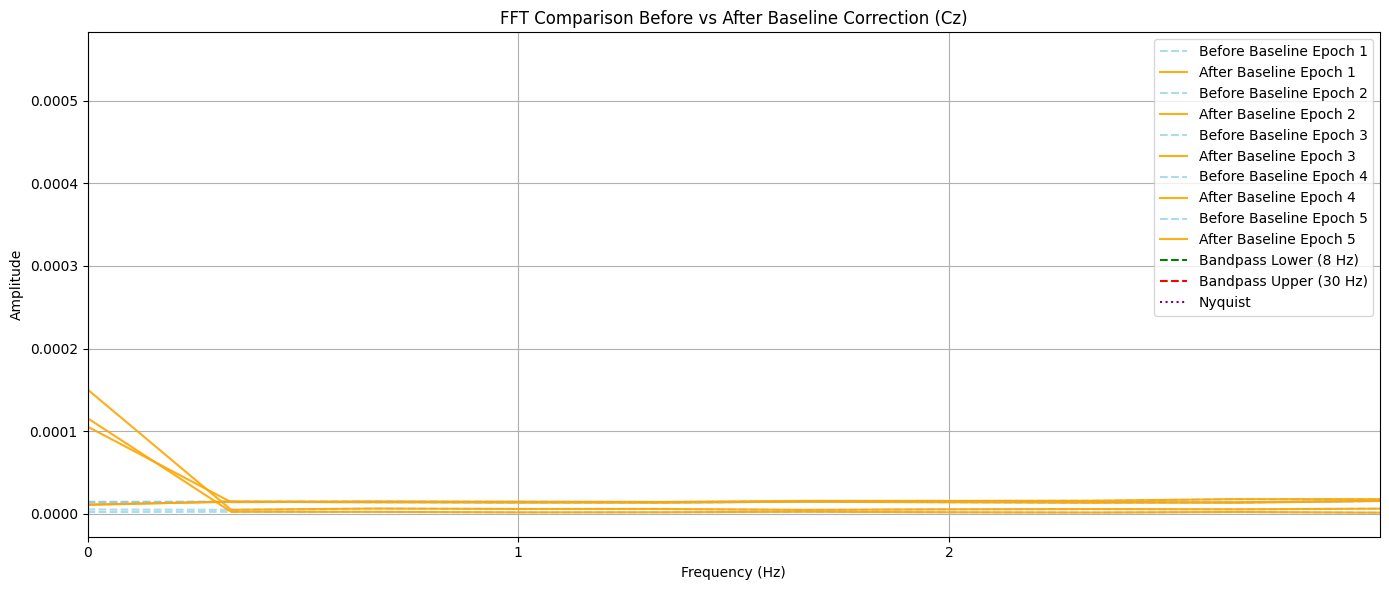

In [39]:
# ตั้งค่าเบื้องต้น
c_name = 'Cz'
c_index = Selected_epochs.ch_names.index(c_name)
fs = Selected_epochs.info['sfreq']

# ดึงข้อมูลก่อนและหลัง baseline correction
data_before = Selected_epochs.get_data()   # ก่อนทำ baseline
data_after = Selectedtuna.get_data()       # หลังทำ baseline

# จำนวน epoch ที่จะดู
Nu = 5

# เริ่ม plot
plt.figure(figsize=(14, 6))

for i in range(Nu):
    # ก่อน baseline
    sig_before = data_before[i, c_index, :]
    fft_before = np.abs(np.fft.rfft(sig_before))
    
    # หลัง baseline
    sig_after = data_after[i, c_index, :]
    fft_after = np.abs(np.fft.rfft(sig_after))
    
    freqs = np.fft.rfftfreq(len(sig_before), 1/fs)
    
    # Plot ทั้งสอง
    plt.plot(freqs, fft_before, label=f'Before Baseline Epoch {i+1}', linestyle='--', alpha=0.7, color='skyblue')
    plt.plot(freqs, fft_after, label=f'After Baseline Epoch {i+1}', linestyle='-', alpha=0.9, color='orange')

# Optional: เส้นอ้างอิง
plt.axvline(8, color='green', linestyle='--', label='Bandpass Lower (8 Hz)')
plt.axvline(30, color='red', linestyle='--', label='Bandpass Upper (30 Hz)')
plt.axvline(fs/2, color='purple', linestyle=':', label='Nyquist')

# การตั้งค่ากราฟ
plt.title(f"FFT Comparison Before vs After Baseline Correction ({c_name})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0,3)
plt.xticks(np.arange(0, 3, 1))  # ticks each 1 Hz
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [40]:
# ก่อน
mean_before = np.mean(Selected_epochs.get_data(), axis=2)  # (n_epochs, n_channels)
mean_after = np.mean(Selectedtuna.get_data(), axis=2)

# ดูค่าเฉลี่ยรวมทุก channel ทุก epoch
print(" Mean ก่อน baseline correction:", np.mean(mean_before))
print(" Mean หลัง baseline correction:", np.mean(mean_after))


 Mean ก่อน baseline correction: 1.877103124245905e-10
 Mean หลัง baseline correction: -7.530126473902142e-10


In [41]:
# ตรวจเฉพาะ C3
c_index = Selected_epochs.ch_names.index('C4')
c_mean_before = np.mean(Selected_epochs.get_data()[:, c_index, :])
c_mean_after = np.mean(Selectedtuna.get_data()[:, c_index, :])

print("C4 Mean ก่อน correction:", c_mean_before)
print("C4 Mean หลัง correction:", c_mean_after)


C4 Mean ก่อน correction: 5.353067003304361e-10
C4 Mean หลัง correction: -1.878114245150301e-09


In [42]:
# # Index ของช่วงเวลา -0.5 ถึง 0s
# times = Selectedtuna.times
# baseline_mask = np.where((times >= -0.5) & (times <= 0))[0]

# # ค่าเฉลี่ยช่วง baseline
# baseline_mean = np.mean(Selectedtuna.get_data()[:, :, baseline_mask])
# print("ค่าเฉลี่ยของช่วง baseline (-0.5 ถึง 0s):", baseline_mean)


In [43]:
#Check time per epoch
n_times = Selectedtuna.get_data().shape[2]  # จำนวน sample ต่อ 1 epoch
sfreq = Selectedtuna.info['sfreq']          # sampling rate (Hz)

# คำนวณ duration
duration_sec = n_times / sfreq
print(f"Duration per epoch: {duration_sec:.3f} seconds")


Duration per epoch: 3.000 seconds


### Step 3: Feature Extraction
- CSP and Check n_components using classification

In [52]:
# Extract data and labels
X = Selectedtuna.get_data()
y = Selectedtuna.events[:, -1]
# Encode label from [1,2,3,4,5,6] → [0,1,2,3,4,5] which model would like to read like this
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded , test_size=0.2, random_state=42)

In [53]:
X.shape

(1800, 16, 384)

In [54]:
# # Create CSP object n_components can adjust 2 4 6 8 <--
# csp = CSP(n_components=16, reg=None, log=True, norm_trace=False)

# # Fit CSP and Transform
# X_csp = csp.fit_transform(X, y_encoded)      # output is feature shape = (n_epochs, n_components)

# # Optional: shape
# print("Feature shape before CSP:", X.shape)
# print("Feature shape after CSP:", X_csp.shape)


In [55]:
# figx = csp.plot_patterns(info=Selectedtuna.info, ch_type='eeg', components=[0, 1, 2, 3,4])

### Step 4: Classification

#### - LDA

Computing rank from data with rank=None
    Using tolerance 2.3e-05 (2.2e-16 eps * 16 dim * 6.5e+09  max singular value)
    Estimated rank (data): 11
    data: rank 11 computed from 16 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 16 -> 11
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Estimating class=4 covariance using EMPIRICAL
Done.
Estimating class=5 covariance using EMPIRICAL
Done.

[TEST] Classification Report
                    precision    recall  f1-score   support

forearm supination       0.28      0.21      0.24        68
   elbow extension       0.28      0.31      0.30        61
 forearm pronation       0.33      0.19      0.25        67
shoulder adduction       0.23      0.29      0.26        49
shoulder abduction       0.33      0.37      0.35

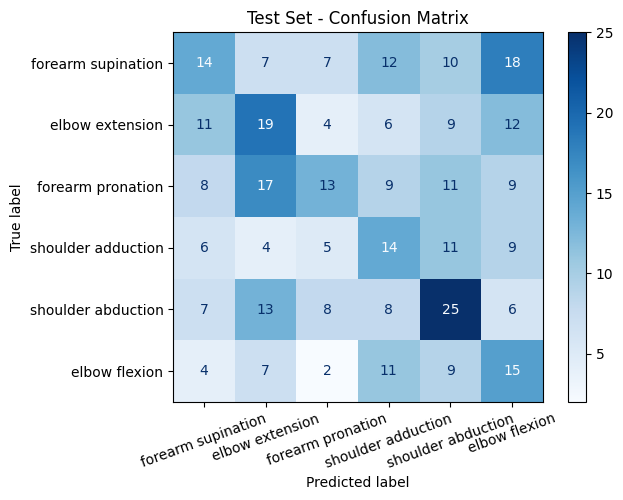


[TRAIN] Classification Report
                    precision    recall  f1-score   support

forearm supination       0.29      0.31      0.30       232
   elbow extension       0.34      0.35      0.35       239
 forearm pronation       0.36      0.28      0.32       233
shoulder adduction       0.31      0.33      0.32       251
shoulder abduction       0.31      0.31      0.31       233
     elbow flexion       0.36      0.38      0.37       252

          accuracy                           0.33      1440
         macro avg       0.33      0.33      0.33      1440
      weighted avg       0.33      0.33      0.33      1440

[TRAIN] Confusion Matrix


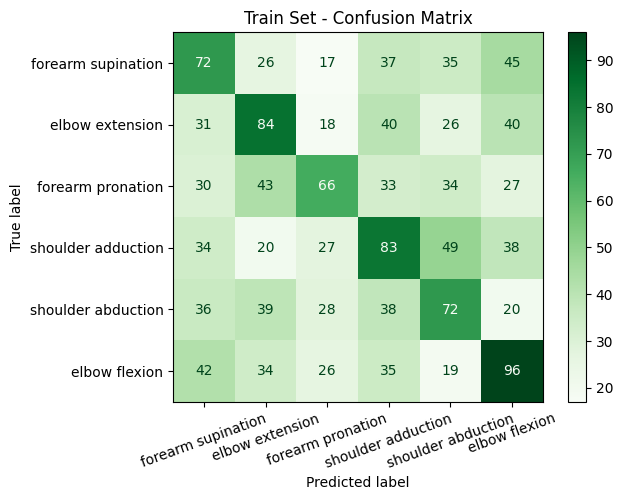

In [48]:
# 1. Fit CSP using ONLY training data
csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)

# 2. Then transform test set with fitted CSP
X_test_csp = csp.transform(X_test)

# 3. ใช้ข้อมูลที่ผ่าน CSP แล้ว
X = X_train_csp
y = y_train
X_test = X_test_csp

n_classes = len(np.unique(y))
event_id_to_name = {v: B for B, v in Selectedtuna.event_id.items()}
class_n = [event_id_to_name[i] for i in sorted(event_id_to_name.keys())]

# GridSearchCV: หา best LDA
lda_pipeline = Pipeline([('clf', LinearDiscriminantAnalysis())])
lda_params = {'clf__solver': ['lsqr', 'eigen'], 'clf__shrinkage': ['auto', None]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lda_grid = GridSearchCV(lda_pipeline, lda_params, cv=cv, scoring='accuracy', n_jobs=-1)
lda_grid.fit(X_train_csp, y_train)

# Final model
best_lda = lda_grid.best_estimator_
best_lda.fit(X_train_csp, y_train)

# ========= TEST SET RESULTS ========= #
y_test_pred = best_lda.predict(X_test_csp)
y_test_proba = best_lda.predict_proba(X_test_csp)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

print("\n[TEST] Classification Report")
print(classification_report(y_test, y_test_pred, target_names=class_n))

print("[TEST] Confusion Matrix")
cm_test = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(cm_test)
disp = ConfusionMatrixDisplay(cm_test, display_labels=class_n)
disp.plot(cmap="Blues")
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()

# ========= TRAIN SET RESULTS ========= #
y_train_pred = best_lda.predict(X_train_csp)
y_train_proba = best_lda.predict_proba(X_train_csp)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

print("\n[TRAIN] Classification Report")
print(classification_report(y_train, y_train_pred, target_names=class_n))

print("[TRAIN] Confusion Matrix")
cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm_train,display_labels=class_n)
disp.plot(cmap="Greens")
plt.title("Train Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()


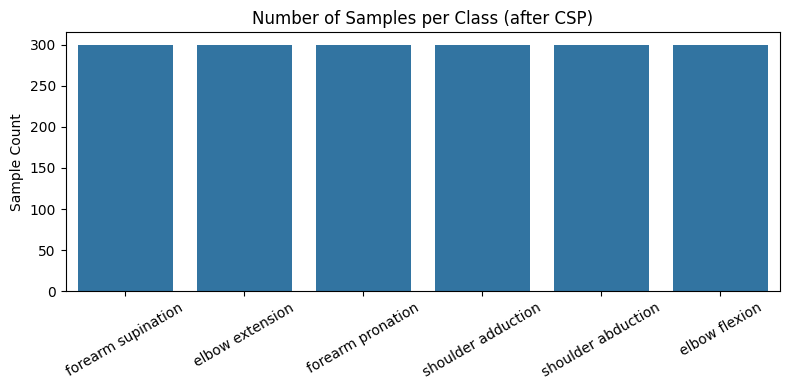

In [49]:
# นับจำนวนแต่ละคลาสหลังทำ CSP
unique_classes, counts = np.unique(y_encoded, return_counts=True)

# แปลง label [0–5] → ชื่อ class (หากใช้ LabelEncoder มาก่อน)
class_names = le.inverse_transform(unique_classes)  # กลับไปเป็น [1–6]
event_name_map = {v: k for k, v in Selectedtuna.event_id.items()}
event_labels = [event_name_map[i] for i in class_names]

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x=event_labels, y=counts)
plt.title("Number of Samples per Class (after CSP)")
plt.ylabel("Sample Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

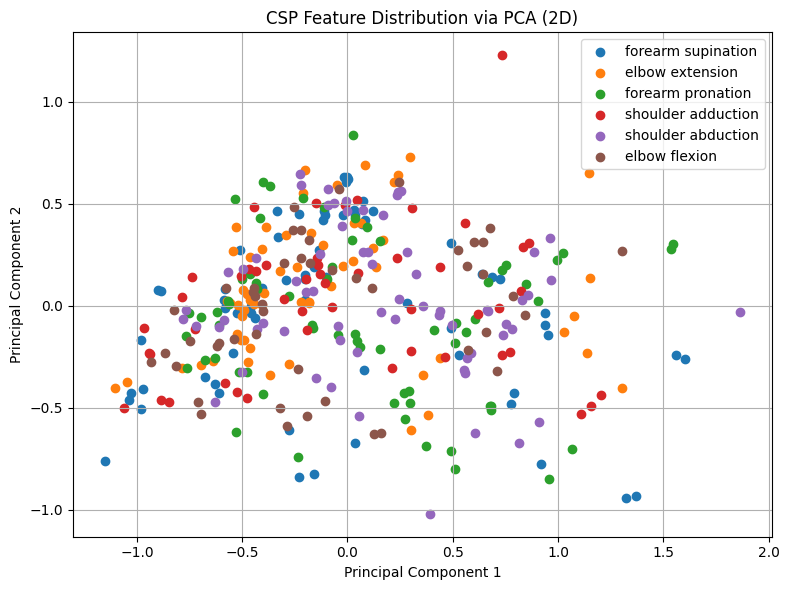

In [50]:
X_pca = PCA(n_components=2).fit_transform(X_test_csp)

plt.figure(figsize=(8, 6))
for class_id in np.unique(y_test):
    class_name = event_id_to_name[le.inverse_transform([class_id])[0]]
    plt.scatter(X_pca[y_test == class_id, 0],
                X_pca[y_test == class_id, 1],
                label=class_name)

plt.title("CSP Feature Distribution via PCA (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### - SVM 

Computing rank from data with rank=None
    Using tolerance 2.3e-05 (2.2e-16 eps * 16 dim * 6.5e+09  max singular value)
    Estimated rank (data): 11
    data: rank 11 computed from 16 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 16 -> 11
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Estimating class=4 covariance using EMPIRICAL
Done.
Estimating class=5 covariance using EMPIRICAL
Done.

[TEST] Classification Report
                    precision    recall  f1-score   support

forearm supination       0.91      0.90      0.90        68
   elbow extension       0.84      0.89      0.86        61
 forearm pronation       0.86      0.81      0.83        67
shoulder adduction       0.80      0.90      0.85        49
shoulder abduction       0.89      0.84      0.86

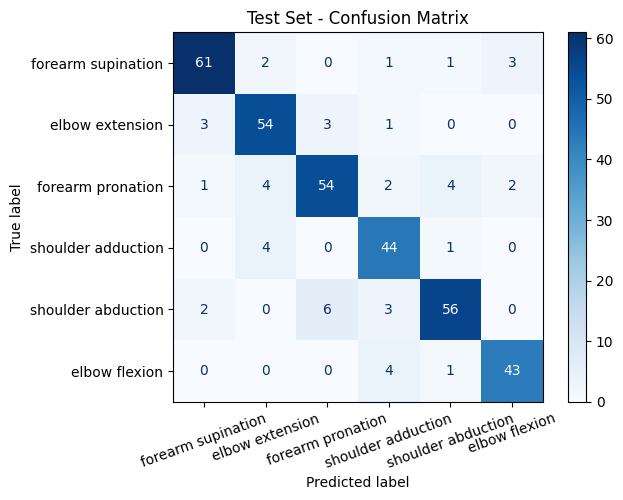


[TRAIN] Classification Report
                    precision    recall  f1-score   support

forearm supination       0.95      0.98      0.96       232
   elbow extension       0.94      0.92      0.93       239
 forearm pronation       0.93      0.91      0.92       233
shoulder adduction       0.96      0.99      0.97       251
shoulder abduction       0.96      0.94      0.95       233
     elbow flexion       0.99      0.98      0.98       252

          accuracy                           0.95      1440
         macro avg       0.95      0.95      0.95      1440
      weighted avg       0.95      0.95      0.95      1440

[TRAIN] Confusion Matrix


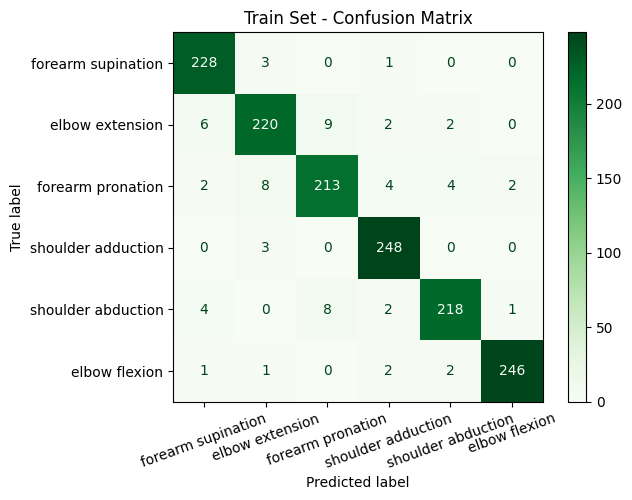

In [56]:
# 1. Fit CSP using ONLY training data
csp = CSP(n_components= 10, reg=None, log=True, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)

# 2. Then transform test set with fitted CSP
X_test_csp = csp.transform(X_test)

# 3. ใช้ข้อมูลที่ผ่าน CSP แล้ว
X = X_train_csp
y = y_train
X_test_final = X_test_csp
n_classes = len(np.unique(y))

n_classes = len(np.unique(y))
event_id_to_name = {v: B for B, v in Selectedtuna.event_id.items()}
class_n = [event_id_to_name[i] for i in sorted(event_id_to_name.keys())]

# GridSearchCV: หา best SVM
svm_pipeline = Pipeline([('clf', SVC(probability=True))])  # ต้องเปิด probability=True เพื่อใช้ ROC AUC
svm_params = {
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto']  # เฉพาะ RBF ใช้ gamma
}
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=cv, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_csp, y_train)

# Final model
best_svm = svm_grid.best_estimator_
best_svm.fit(X_train_csp, y_train)

# ========= TEST SET =========
y_test_pred = best_svm.predict(X_test_final)
y_test_proba = best_svm.predict_proba(X_test_final)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

print("\n[TEST] Classification Report")
print(classification_report(y_test, y_test_pred, target_names=class_n))

print("[TEST] Confusion Matrix")
cm_test = confusion_matrix(y_test, y_test_pred)
dis = ConfusionMatrixDisplay(cm_test,display_labels=class_n)
dis.plot(cmap="Blues")
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()


# ========= TRAIN SET =========
y_train_pred = best_svm.predict(X_train_csp)
y_train_proba = best_svm.predict_proba(X_train_csp)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

print("\n[TRAIN] Classification Report")
print(classification_report(y_train, y_train_pred, target_names=class_n))

print("[TRAIN] Confusion Matrix")
cm_train = confusion_matrix(y_train, y_train_pred)
dis2 = ConfusionMatrixDisplay(cm_train,display_labels=class_n)
dis2.plot(cmap="Greens")
plt.title("Train Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()


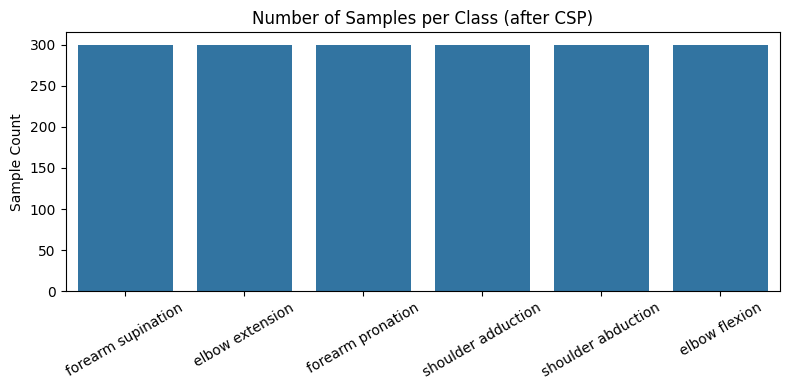

In [57]:
# นับจำนวนแต่ละคลาสหลังทำ CSP
unique_classes, counts = np.unique(y_encoded, return_counts=True)

# แปลง label [0–5] → ชื่อ class (หากใช้ LabelEncoder มาก่อน)
class_names = le.inverse_transform(unique_classes)  # กลับไปเป็น [1–6]
event_name_map = {v: k for k, v in Selectedtuna.event_id.items()}
event_labels = [event_name_map[i] for i in class_names]

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x=event_labels, y=counts)
plt.title("Number of Samples per Class (after CSP)")
plt.ylabel("Sample Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [58]:
# X_pca = PCA(n_components=2).fit_transform(X_test_csp)

# plt.figure(figsize=(8, 6))
# for class_id in np.unique(y_test):
#     class_name = event_id_to_name[le.inverse_transform([class_id])[0]]
#     plt.scatter(X_pca[y_test == class_id, 0],
#                 X_pca[y_test == class_id, 1],
#                 label=class_name)

# plt.title("CSP Feature Distribution via PCA (2D)")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [59]:
plt.figure(figsize=(10, 6))
for class_id in np.unique(y_encoded):
    # เลือก index ของ class นั้น
    idx = np.where(y_encoded == class_id)[0]
    
    # แปลง label เป็นชื่อ class
    class_name = event_id_to_name[le.inverse_transform([class_id])[0]]
    
    plt.scatter(X_csp[idx, 0], X_csp[idx, 1], label=class_name, alpha=0.7)

# ตกแต่งกราฟ
plt.title("2D Scatter of CSP Features (CSP0 vs CSP1) for 6 Classes")
plt.xlabel("CSP Component 0")
plt.ylabel("CSP Component 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'X_csp' is not defined

### Evaluation abd Visualization 🔰

#### ERD ERS ploting each class Cz C3 C4 in difference(6 Class)

▶️ Plotting ERD/ERS for class: forearm supination
Applying baseline correction (mode: mean)


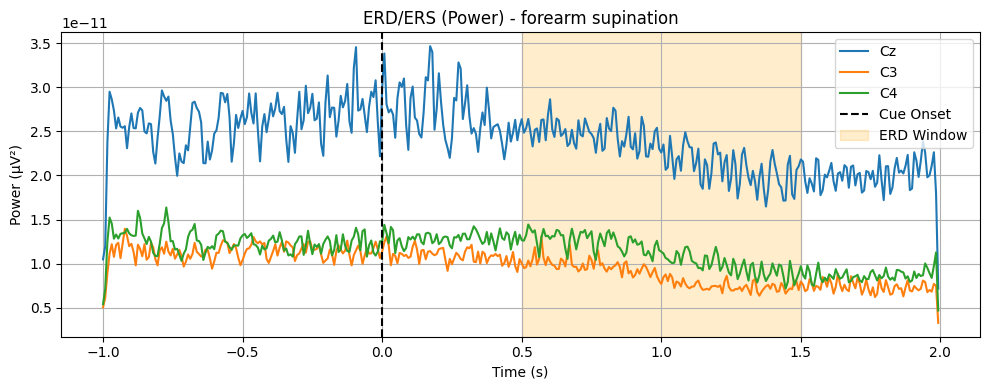

▶️ Plotting ERD/ERS for class: elbow extension
Applying baseline correction (mode: mean)


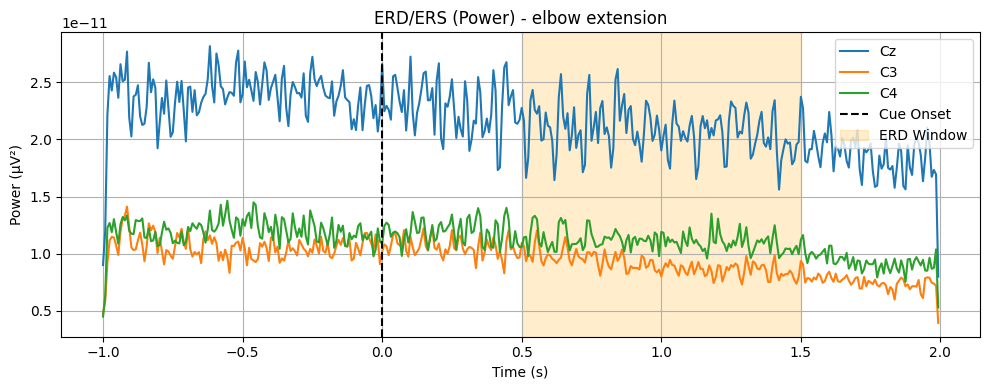

▶️ Plotting ERD/ERS for class: forearm pronation
Applying baseline correction (mode: mean)


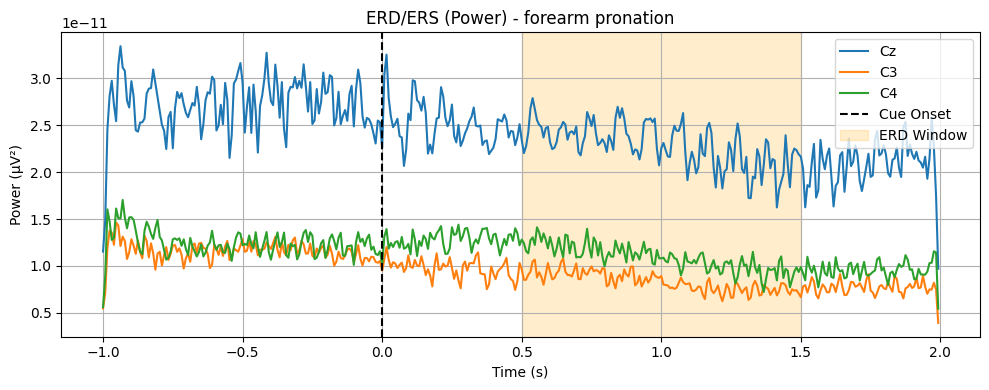

▶️ Plotting ERD/ERS for class: shoulder adduction
Applying baseline correction (mode: mean)


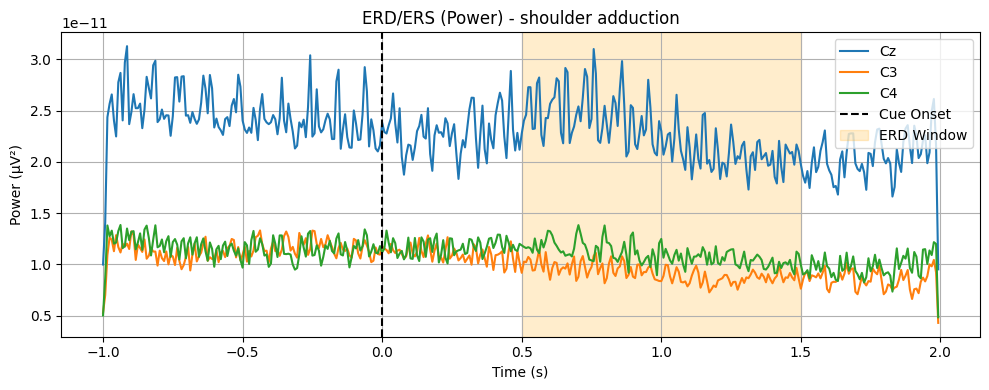

▶️ Plotting ERD/ERS for class: shoulder abduction
Applying baseline correction (mode: mean)


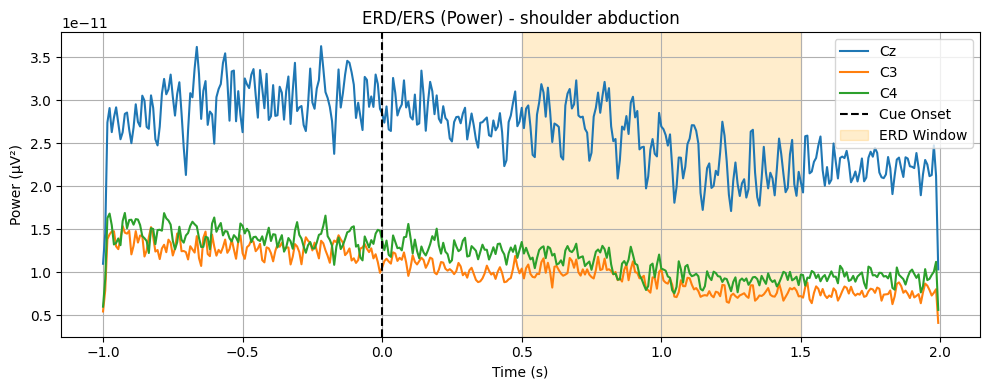

▶️ Plotting ERD/ERS for class: elbow flexion
Applying baseline correction (mode: mean)


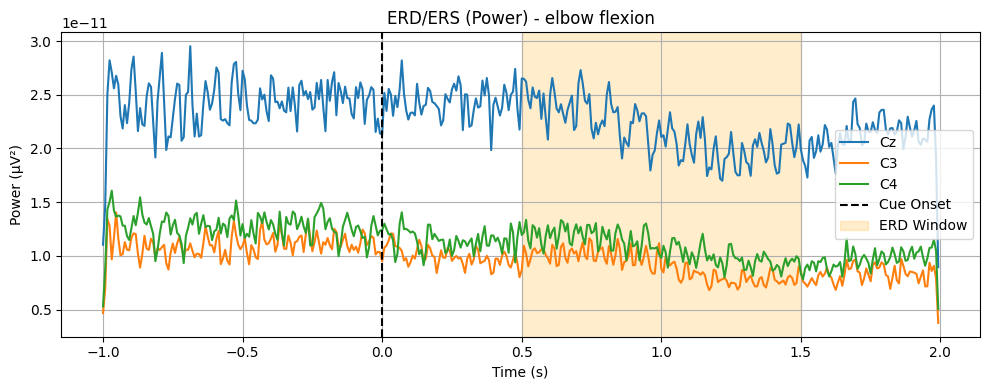

In [ ]:
# Parameters
channels = ['Cz', 'C3', 'C4']
baseline = (-0.5, 0)
erd_window = (0.5, 1.5)  # window of interest
event_labels = Selectedtuna.event_id

# Step through each class
for class_name, class_id in event_labels.items():
    print(f"▶️ Plotting ERD/ERS for class: {class_name}")
    
    # Select only this class
    epochs_class = Selectedtuna[class_name]

    # Baseline correction
    epochs_class.apply_baseline(baseline)

    # Get data: shape = (n_epochs, n_channels, n_times)
    data = epochs_class.get_data()
    times = epochs_class.times

    # Average across trials
    avg_power = np.mean(data ** 2, axis=0)  # shape = (n_channels, n_times)

    # Plot ERD/ERS curve for Cz, C3, C4
    plt.figure(figsize=(10, 4))
    for ch in channels:
        ch_idx = epochs_class.ch_names.index(ch)
        plt.plot(times, avg_power[ch_idx], label=ch)

    plt.title(f"ERD/ERS (Power) - {class_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Power (µV²)")
    plt.axvline(0, color='black', linestyle='--', label='Cue Onset')
    plt.axvspan(*erd_window, color='orange', alpha=0.2, label='ERD Window')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Topomap plot powerspectrum ERD* (each 6 class)

 Power Topomap (8–30Hz) for: forearm supination
    Using multitaper spectrum estimation with 7 DPSS windows


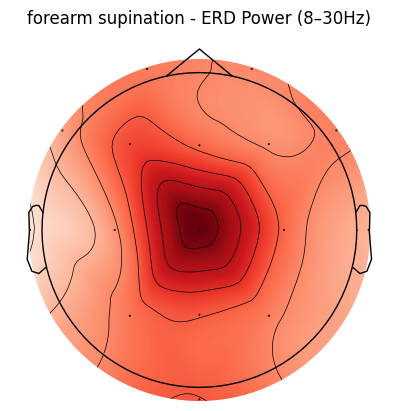

 Power Topomap (8–30Hz) for: elbow extension
    Using multitaper spectrum estimation with 7 DPSS windows


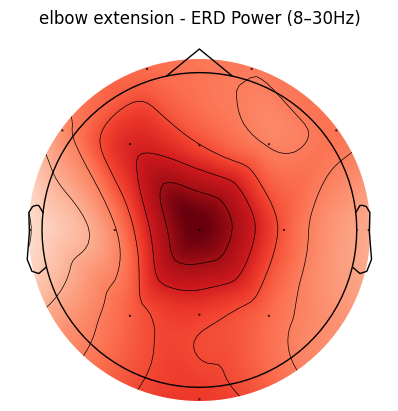

 Power Topomap (8–30Hz) for: forearm pronation
    Using multitaper spectrum estimation with 7 DPSS windows


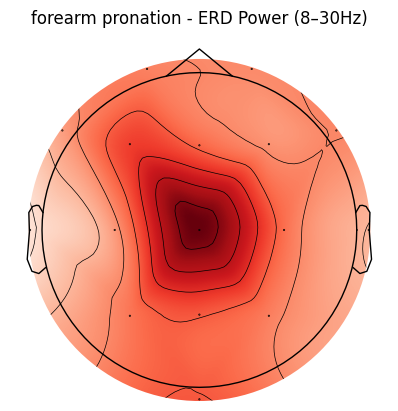

 Power Topomap (8–30Hz) for: shoulder adduction
    Using multitaper spectrum estimation with 7 DPSS windows


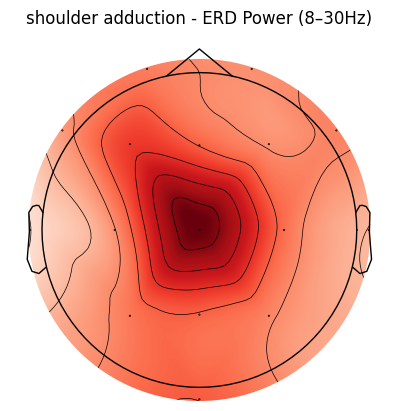

 Power Topomap (8–30Hz) for: shoulder abduction
    Using multitaper spectrum estimation with 7 DPSS windows


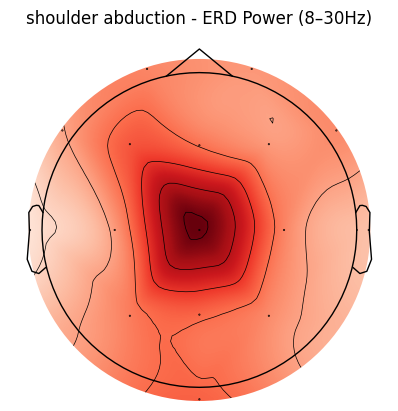

 Power Topomap (8–30Hz) for: elbow flexion
    Using multitaper spectrum estimation with 7 DPSS windows


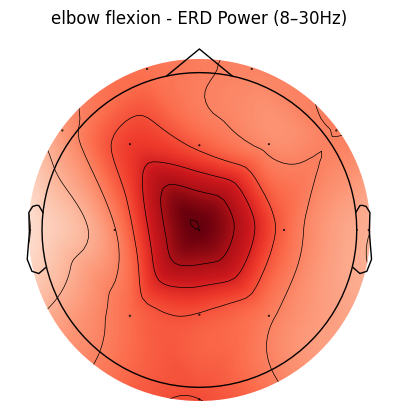

In [ ]:
for class_name in event_labels:
    print(f" Power Topomap (8–30Hz) for: {class_name}")
    epochs_class = Selectedtuna[class_name]

    # ใช้ compute_psd() แทน
    psd = epochs_class.copy().crop(tmin=erd_window[0], tmax=erd_window[1]).compute_psd(fmin=8, fmax=30)
    mean_power = psd.get_data().mean(axis=0).mean(axis=1)  # avg over trials + freqs → shape (n_channels,)

    # Plot topomap
    fig, ax = plt.subplots()
    mne.viz.plot_topomap(mean_power, epochs_class.info, axes=ax, show=False)
    ax.set_title(f"{class_name} - ERD Power (8–30Hz)")
    plt.show()
